Notebook to implement spinning of icospheres




In [1]:
#ico class
import os
import numpy as np
import nibabel as nb
import copy
from scipy import sparse 
import meld_classifier.mesh_tools as mt
from math import pi 
import logging
from meld_graph.icospheres import IcoSpheres
import matplotlib_surface_plotting as msp
from scipy.stats import special_ortho_group
from scipy.spatial import cKDTree
# import logging
logging.basicConfig(level=logging.DEBUG)

Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
No fs_subjects_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!


/home/kw350/.conda/envs/meld_graph/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### test class augment
from meld_graph.augment import Augment
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_graph.dataset import GraphDataset

icos=IcoSpheres(conv_type='SpiralConv')
ico_index=7
ico_ini = icos.icospheres[ico_index]

#test on subject
site_codes=['H4']
subjects = ['MELD_H4_3T_FCD_0011']
features=  [  '.combat.on_lh.pial.K_filtered.sm20.mgh',
        '.combat.on_lh.thickness.sm10.mgh',
        '.combat.on_lh.w-g.pct.sm10.mgh',
#         '.combat.on_lh.sulc.sm5.mgh',
#         '.combat.on_lh.curv.sm5.mgh',
#         '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
#         '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
#         '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
#         '.combat.on_lh.gm_FLAIR_0.sm10.mgh',
#         '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
#         '.combat.on_lh.wm_FLAIR_1.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
#         '.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.sulc.sm5.mgh',
#         '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh',
#         '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
#         '.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
#         '.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh',
           ]
            
# initiate params
def load_config(config_file):
    """load config.py file and return config object"""
    import importlib.machinery, importlib.util

    loader = importlib.machinery.SourceFileLoader("config", config_file)
    spec = importlib.util.spec_from_loader(loader.name, loader)
    config = importlib.util.module_from_spec(spec)
    loader.exec_module(config)
    return config

config = load_config('../scripts/config_files/example_experiment_config.py')
config.data_parameters['features']=features
config.data_parameters['site_codes']=site_codes
config.data_parameters['synthetic_data']['n_subs']=10

subjects = ['MELD_H4_3T_FCD_0011']
config.data_parameters['augment_data'] = {'spinning': {'p': 0.2, 'file': 'data/spinning/spinning_ico7_10_nearest.npy'},
 'warping': {'p': 0.2, 'file': 'data/warping/warping_ico7_10_nearest.npy'},
 'noise': {'p': 0.15},
 'blur': {'p': 0.2},
 'brightness': {'p': 0.15},
 'contrast': {'p': 0.15},
 'low_res': {'p': 0.25},
 'gamma': {'p': 0.15},
 'flipping': {'p': 0.5, 'file': 'data/flipping/flipping_ico7_3_nearest.npy'}}
cohort = MeldCohort(
            hdf5_file_root=config.data_parameters["hdf5_file_root"], dataset=config.data_parameters["dataset"]
        )
dataset = GraphDataset(subjects, cohort, config.data_parameters )


# features_subj, labels_subj = dataset.data_list[0]


# augment = Augment(params)

# spinned_feature, spinned_lesion = augment.apply(features_sub, labels_subj)

# spinned_feature, spinned_lesion = dataset.get(0)
#dataset_augment = dataset.get(0)


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:meld_graph.icospheres:Using coord type pseudo
INFO:meld_graph.dataset:Loading and preprocessing train data
DEBUG:meld_graph.dataset:Combine hemis None
DEBUG:meld_graph.icospheres:Using coord type pseudo
INFO:meld_graph.dataset:WARNING: Simulating 9 subjects using 1 controls
DEBUG:meld_classifier.meld_cohort:missing feature: .on_lh.lesion.mgh set to zero
INFO:meld_graph.data_preprocessing:Z-scoring data for MELD_H4_3T_FCD_0011


In [26]:
dset=dataset.get(0)


(163842,)


In [3]:
params = config.data_parameters
params['augment_data'] = {'spinning': {'p': 0.2, 'file': 'data/spinning/spinning_ico7_10_nearest.npy'},
 'warping': {'p': 0.2, 'file': 'data/warping/warping_ico7_10_nearest.npy'},
 'noise': {'p': 0.15},
 'blur': {'p': 0.2},
 'brightness': {'p': 0.15},
 'contrast': {'p': 0.15},
 'low_res': {'p': 0.25},
 'gamma': {'p': 0.15},
 'flipping': {'p': 0.5, 'file': 'data/flipping/flipping_ico7_3_nearest.npy'}}


NameError: name 'param' is not defined

In [5]:
np.load('../data/flipping/flipping_ico7_3_nearest.npy').shape

(3, 163842)

In [6]:
augment = Augment(params['augment_data'])

In [7]:
features_subj, labels_subj = dataset.data_list[0]
spinned_feature_n, spinned_lesion_n = augment.spinning.apply_transform_nearest(features_subj, labels_subj)
#spinned_feature_f, spinned_lesion_f = augment.spinning.apply_transform(features_subj, labels_subj)

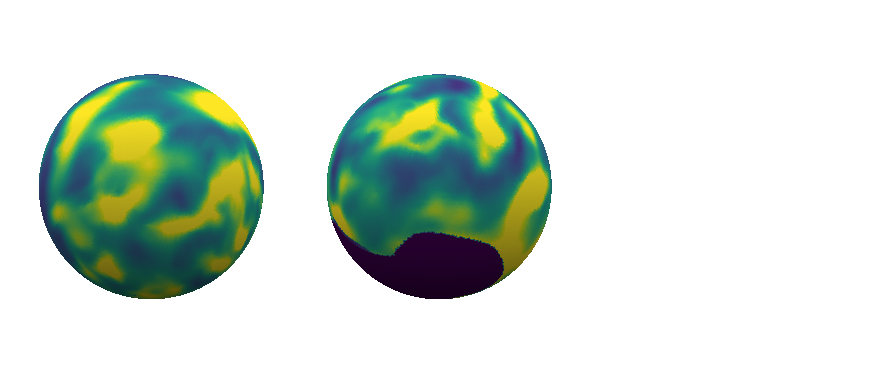

In [13]:
dset=dataset.get(0)
features_subj=dset['x'][:,0].numpy()
labels_subj=dset['y'].numpy()
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj, parcel=labels_subj,
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2,vmax=2
                 );

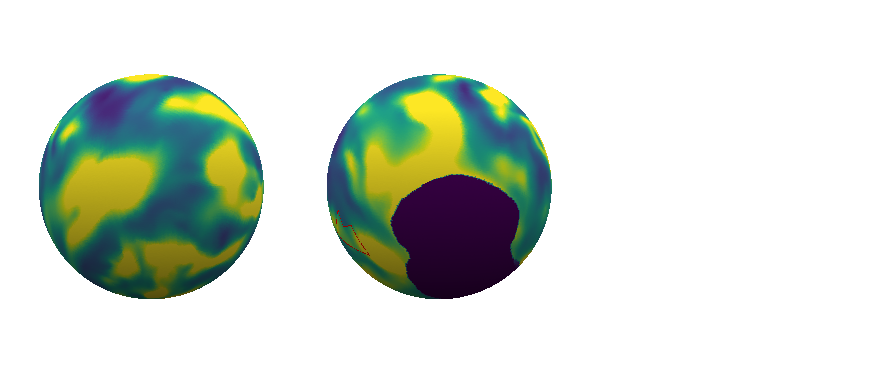

In [28]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj, parcel=labels_subj,
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2,vmax=2
                 );

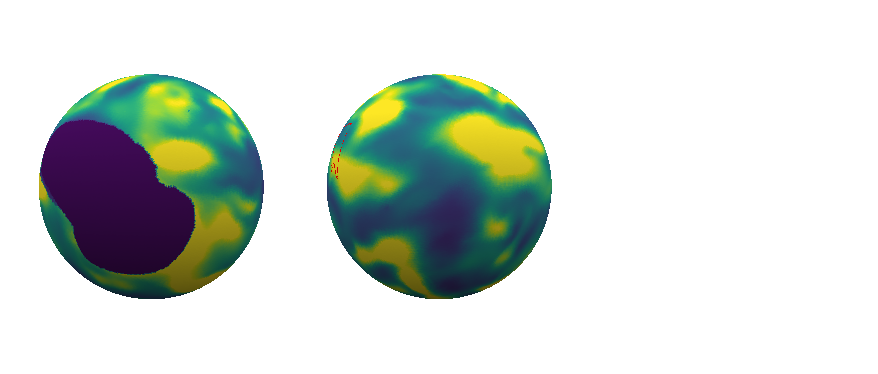

In [7]:

msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              spinned_feature_n[:,0], parcel=spinned_lesion_n,
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2,vmax=2
                 );

In [13]:
features_subj, labels_subj = dataset.data_list[0]
import time
t1=time.time()
for k in np.arange(100):
    if k%100==0:
        t2=time.time()
        print(t2-t1)
    spinned_feature, spinned_lesion = augment.spinning.apply_transform_nearest(features_subj, labels_subj)
t2=time.time()
print(t2-t1)

0.00015664100646972656
18.056885719299316


In [14]:
features_subj, labels_subj = dataset.data_list[0]
import time
t1=time.time()
for k in np.arange(100):
    if k%100==0:
        t2=time.time()
        print(t2-t1)
    spinned_feature, spinned_lesion = augment.spinning.apply_transform(features_subj, labels_subj)
t2=time.time()
print(t2-t1)

8.440017700195312e-05
43.33342123031616


In [ ]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              spinned_feature[:,0], parcel=spinned_lesion,
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2,vmax=2
                 );

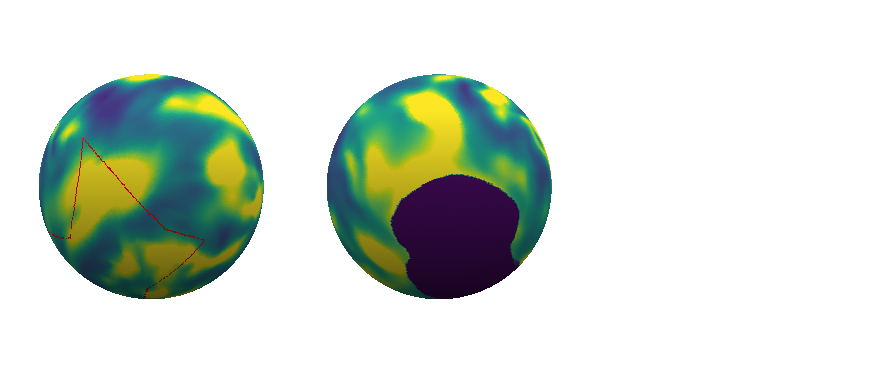

In [32]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj[:,0], parcel=labels_subj,
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2,vmax=2
                 );

In [23]:
spinned_feature[:,0]

array([-0.13766286, -1.02065183,  2.42132968, ...,  0.63542337,
        0.6724295 ,  0.63487662])

In [81]:
def create_lesion_mask(self,radius,cartesian_coords,return_smoothed=True):
        """create irregular polygon lesion mask"""
        import matplotlib.path as mpltPath
        #from sklearn.metrics import pairwise_distances
        from scipy import interpolate,ndimage
        import copy
        from meld_graph.resampling_meshes import spinning_coords
        from meld_classifier import mesh_tools as mt
        spun_coords = spinning_coords(cartesian_coords)
        spherical_coords = mt.spherical_np(spun_coords)[:,1:]
        spherical_coords[:,0] = spherical_coords[:,0]-np.pi/2
        spherical_coords = self.clip_spherical_coords(spherical_coords)

        #select a radius
        f_radius = np.clip(np.random.normal(radius,radius/2),0.05,2)
        n_points = np.random.choice(6)+4
        subset = self.grid_coords[self.distances<f_radius]
        #establish mask and mask coordinates
        x_mask = np.logical_and(self.grid_coords_grid[0]>-f_radius,self.grid_coords_grid[0]<f_radius)
        y_mask = np.logical_and(self.grid_coords_grid[1]>-f_radius,self.grid_coords_grid[1]<f_radius)
        grid_mask = np.logical_and(x_mask
            ,y_mask
            )
        mask_shape=(x_mask.any(axis=1).sum(),y_mask.any(axis=0).sum())
        masked_grid_coords = np.vstack([self.grid_coords_grid[0][grid_mask],
                      self.grid_coords_grid[1][grid_mask]]).T
        
        poly_i = np.random.choice(len(subset),n_points)
        polygon = subset[poly_i]
        polygon = np.array(sorted(polygon, key=lambda point: self.clockwiseangle_and_distance(point,self.origin)))
        path = mpltPath.Path(polygon)
        lesion = path.contains_points(masked_grid_coords)
        #lesion = path.contains_points(self.grid_coords)
        arr_lesion = lesion.reshape(mask_shape).astype(float)
        #arr_lesion = lesion.reshape(self.gridshape,order='f').astype(float)
        #interpolate to coordinates
        
        full_lesion = np.zeros(self.gridshape,dtype=float)
        full_lesion[grid_mask.T] = arr_lesion.T.ravel()
        f_near=interpolate.RegularGridInterpolator((self.xnew,self.ynew),
                                                   full_lesion.T,
                                                  method='nearest')
        interpolated_lesion=f_near(spherical_coords)
        #smoothed mask
        if return_smoothed:
            smoothed = ndimage.gaussian_filter(arr_lesion,10)
            full_lesion[grid_mask.T] = smoothed.T.ravel()

            f_lin=interpolate.RegularGridInterpolator((self.xnew,self.ynew),
                                                   full_lesion.T,
                                                  method='linear')
            #return grid_coords,smoothed
            interpolated_smoothed = f_lin(spherical_coords)
            return interpolated_lesion, interpolated_smoothed 
        else:
            return interpolated_lesion

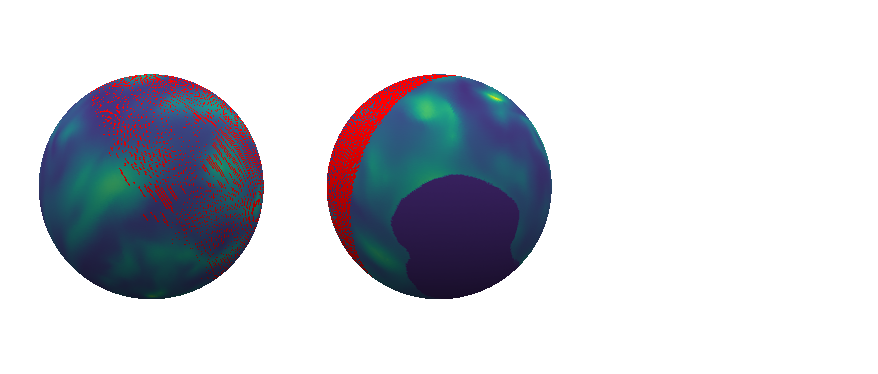

In [26]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj[:,0], parcel=labels_subj,
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2.5,vmax=7
                 )

In [10]:
dataset_augment = dataset.get(0)

DEBUG:meld_graph.augment:apply Gaussian noise
DEBUG:meld_graph.augment:apply Brightness scaling


In [26]:
d = np.zeros((10,len(dataset_augment['x'][:,0].numpy())))
for k in np.arange(10):
    dataset_augment = dataset.get(0)
    d[k]=dataset_augment['x'][:,0].numpy()

DEBUG:meld_graph.augment:apply Gaussian noise
DEBUG:meld_graph.augment:apply low res
DEBUG:meld_graph.augment:apply Brightness scaling
DEBUG:meld_graph.augment:apply Gaussian blur
DEBUG:meld_graph.augment:apply Brightness scaling
DEBUG:meld_graph.augment:apply gamma
DEBUG:meld_graph.augment:apply gamma
DEBUG:meld_graph.augment:apply gamma
DEBUG:meld_graph.augment:apply Brightness scaling
DEBUG:meld_graph.augment:apply Brightness scaling
DEBUG:meld_graph.augment:apply gamma
DEBUG:meld_graph.augment:apply Gaussian blur
DEBUG:meld_graph.augment:apply Brightness scaling
DEBUG:meld_graph.augment:apply Brightness scaling
DEBUG:meld_graph.augment:apply low res
DEBUG:meld_graph.augment:apply gamma


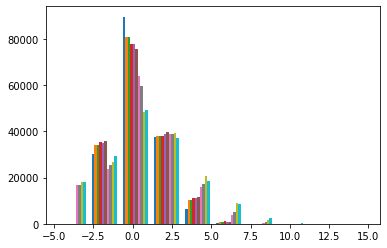

In [29]:
plt.hist(d.T);

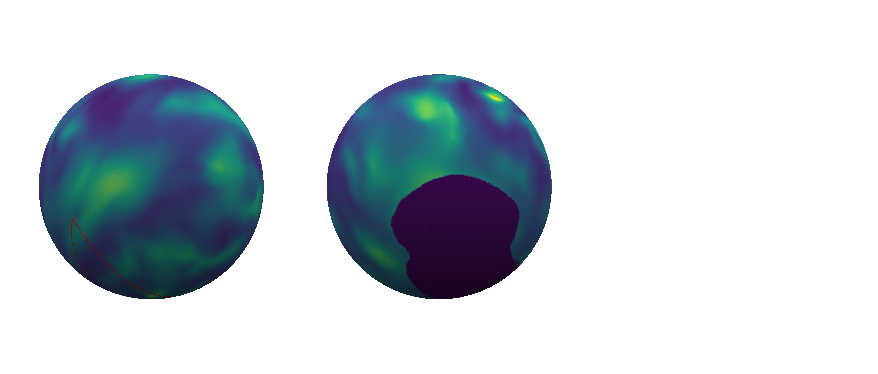

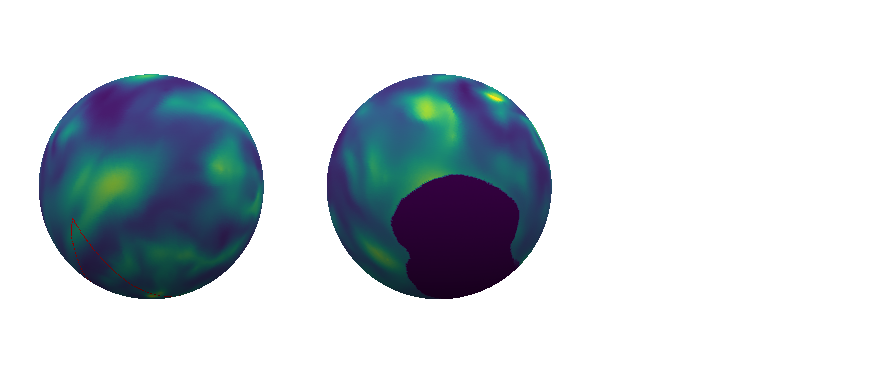

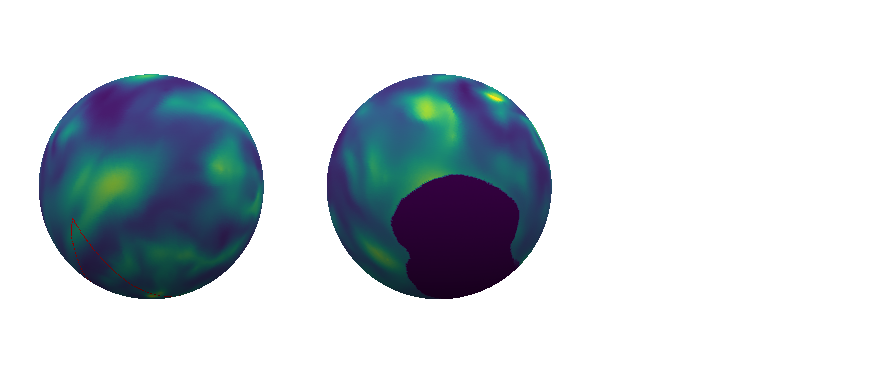

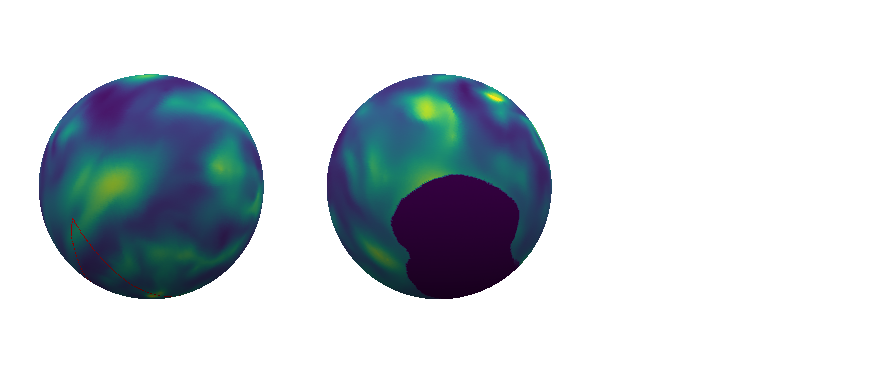

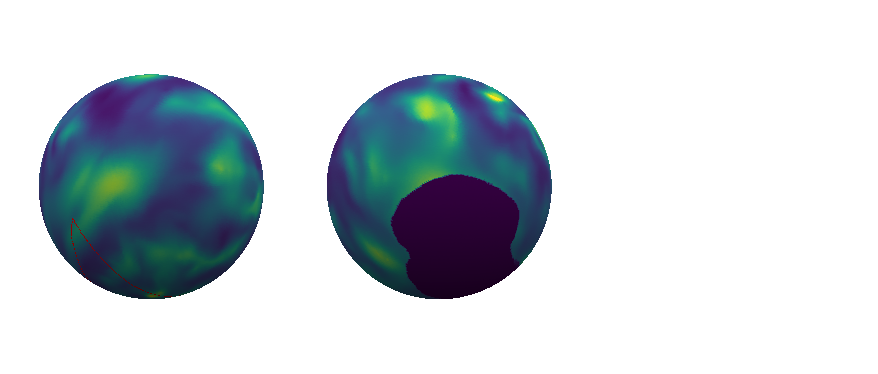

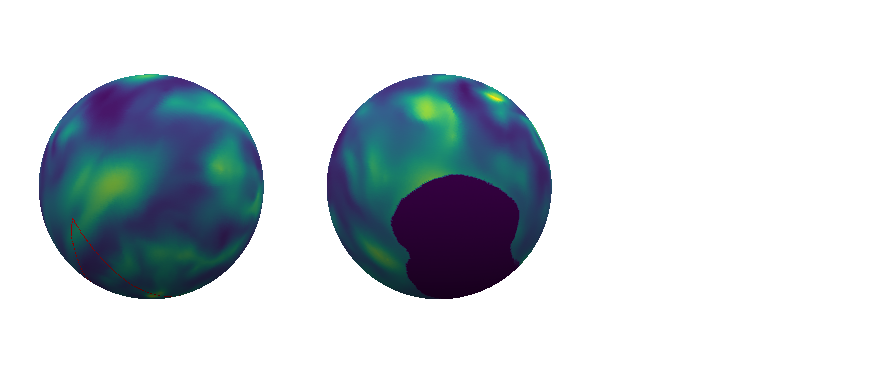

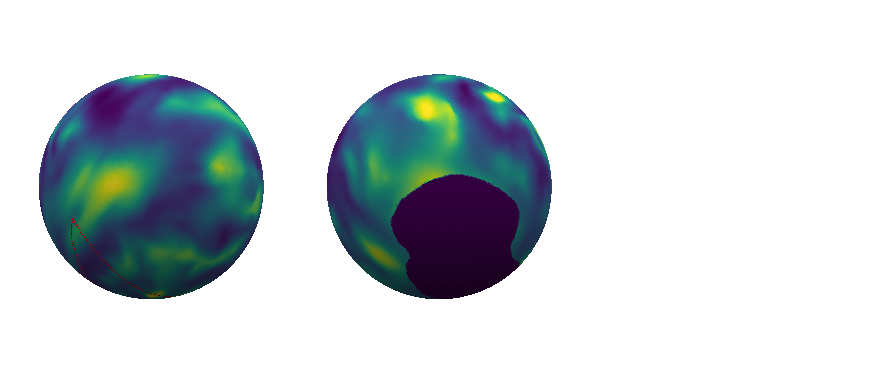

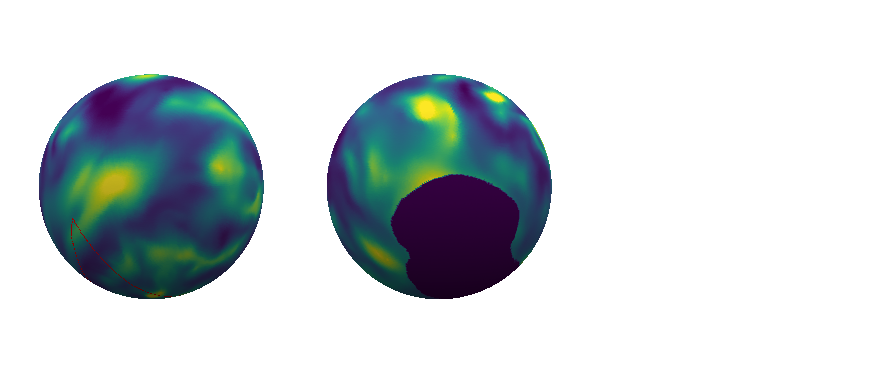

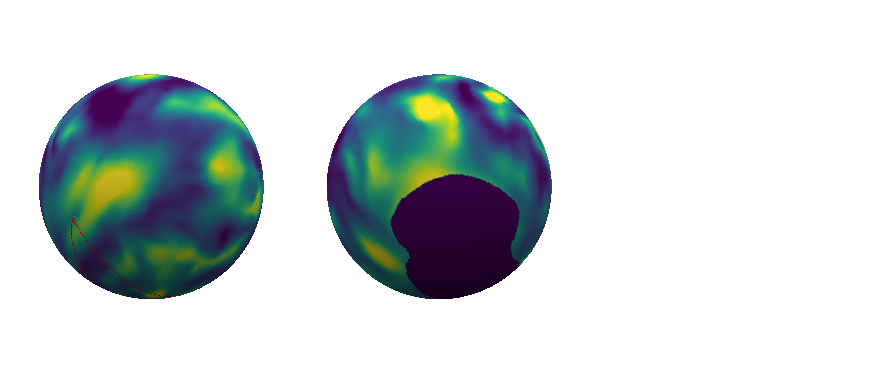

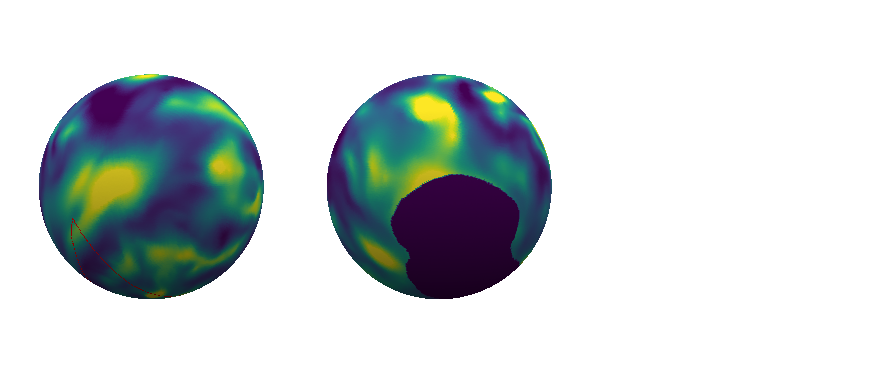

In [30]:
for k in np.arange(10):
    msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              d[k], parcel=dataset_augment['y'].numpy(),
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                  vmin=-2.5,vmax=7
                 )

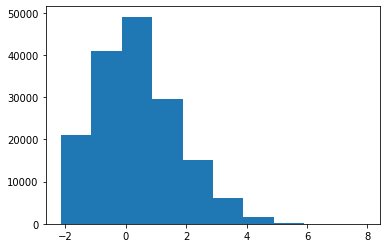

In [20]:
import matplotlib.pyplot as plt
plt.hist(dataset_augment['x'][:,0].numpy());

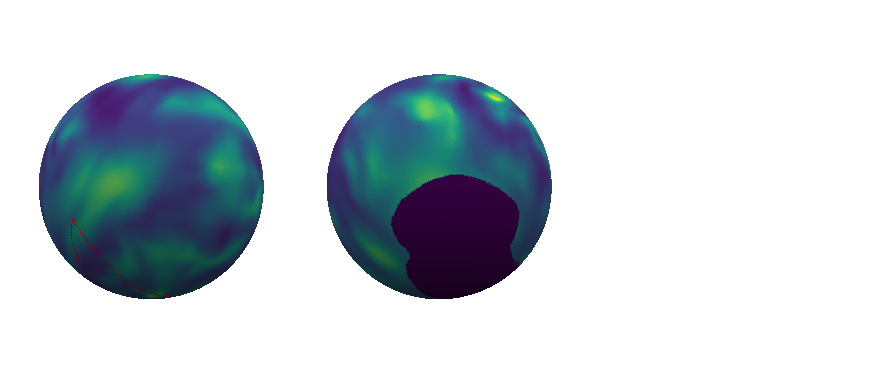

In [14]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              dataset_augment['x'][:,0].numpy(), parcel=dataset_augment['y'].numpy(),
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                 )


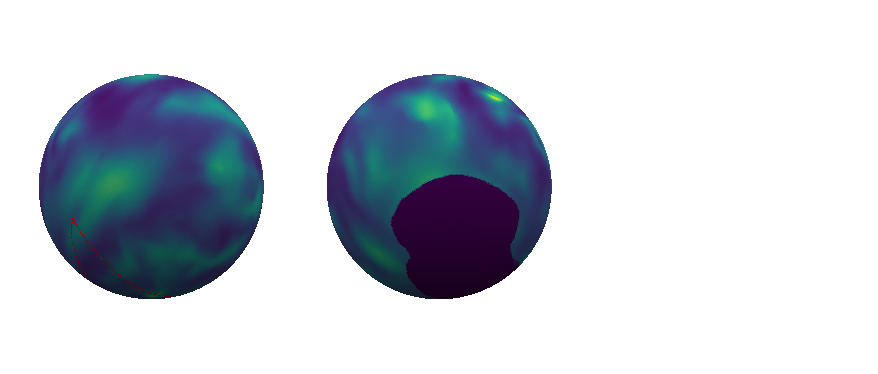

In [17]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              dataset_augment['x'][:,0].numpy(), parcel=dataset_augment['y'].numpy(),
              filled_parcels=False,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[90,270], 
                 )


In [ ]:
import time

def fastind(a, rows, cols):
    return (a.ravel()[(cols + (rows * a.shape[1]).reshape((-1,1))).ravel()]).reshape(rows.size, cols.size)

a = np.random.randn(3218, 1415)
print(a.shape)
# rows = np.random.randint(a.shape[0], size=2000)
rows=np.arange(0, len(a))
print(rows)
# cols = np.array([1,3,4,5])
cols=np.array([5])
print(cols)

# start_time = time.process_time()
# result1 = a[rows][:, cols]
# end_time =time.process_time()
# print("execution time 1= " + str(end_time - start_time) + " seconds")


# start_time = time.process_time()
# b = fastind(a,rows, cols)
# end_time =time.process_time()
# print("execution time 2= " + str(end_time - start_time) + " seconds")

In [ ]:
timeit (a.ravel()[(cols + (rows * a.shape[1]).reshape((-1,1))).ravel()]).reshape(rows.size, cols.size)

In [ ]:
timeit fastind(a, rows,cols)

In [17]:
timeit fastind(a,rows, cols)

46 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [3]:
set(augment.params)

{'augment_data',
 'combine_hemis',
 'features',
 'lobes',
 'preprocessing_parameters'}

In [5]:
import time
lambdas, indices = np.load(os.path.join('/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'))
indices = indices.astype('int') 

feats=np.zeros((len(ico_ini['coords']), 11))
lesions=np.zeros(len(ico_ini['coords']))

start_time = time.process_time()
# select random transformation parameter
transf = 0
# spin lesions if exist
if lesions.any()!= None:            
    lesions_transf = lambdas[transf,:,0]*lesions[indices[transf,:,0]] + lambdas[transf,:,1]*lesions[indices[transf,:,1]] + lambdas[transf,:,2]*lesions[indices[transf,:,2]]   
    lesions_transf = np.round(lesions_transf)
# spin features
n_feat = len(feats.T)
lambdas = np.tile(lambdas[:,:,:,np.newaxis], n_feat )
feats_transf = lambdas[transf,:,0]*feats[indices[transf,:,0]] + lambdas[transf,:,1]*feats[indices[transf,:,1]] + lambdas[transf,:,2]*feats[indices[transf,:,2]]        
feats_transf_clean=np.zeros(feats_transf.shape)
for i in range(0,n_feat):
    feats_transf_clean[:,i]=np.clip(feats_transf[:,i], np.percentile(feats_transf[:,i], 0.01),np.percentile(feats_transf[:,i], 99.9))  
end_time =time.process_time()
print("execution time 1= " + str(end_time - start_time) + " seconds")

execution time 1= 0.5318231220000005 seconds


In [102]:
def fastind(a, rows, cols):
    return (a.ravel()[(cols + (rows * a.shape[1]).reshape((-1,1))).ravel()]).reshape(rows.size, cols.size)
lambdas, indices = np.load(os.path.join('/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'))
indices = indices.astype('int') 

feats=np.zeros((len(ico_ini['coords']), 11))
lesions=np.zeros(len(ico_ini['coords']))

start_time = time.process_time()
# select random transformation parameter
transf = 0
indices=copy.deepcopy(indices[transf])
i0=indices[:,0]
i1=indices[:,1]
i2=indices[:,2]
lambdas=copy.deepcopy(lambdas[transf])
l0=lambdas[:,0]
l1=lambdas[:,1]
l2=lambdas[:,2]
#spin lesions if exist
if lesions.any()!= None:            
    lesions_transf = l0*lesions[i0] + l1*lesions[i1] + l2*lesions[i2]   
    lesions_transf = np.round(lesions_transf)
# spin features
n_feat = len(feats.T)
# l0 = np.tile(l0[:,np.newaxis], n_feat)
# l1 = np.tile(l1[:,np.newaxis], n_feat)
# l2 = np.tile(l2[:,np.newaxis], n_feat)
# feats_transf = l0*feats[i0] + l1*feats[i1] + l2*feats[i2]        
# feats_transf_clean=np.zeros(feats_transf.shape)
# feats_transf_clean=np.clip(feats_transf, np.percentile(feats_transf, 0.01),np.percentile(feats_transf, 99.9))  
end_time =time.process_time()
print("execution time 2= " + str(end_time - start_time) + " seconds")

execution time 2= 0.019229922999997484 seconds


In [101]:
start_time = time.process_time()
feats_transf_clean=np.zeros(feats_transf.shape)
for i in range(0,n_feat):
    feat_temp=feats_transf[:,i]
    feat_temp = l0*feat_temp[i0] + l1*feat_temp[i1] + l2*feat_temp[i2]        
    feats_transf_clean[:,i]=np.clip(feat_temp, np.percentile(feat_temp, 0.01),np.percentile(feat_temp, 99.9))  
end_time =time.process_time()
print("execution time 2= " + str(end_time - start_time) + " seconds")

execution time 2= 0.14500021799999274 seconds


In [103]:
start_time = time.process_time()
l0 = np.tile(l0[:,np.newaxis], n_feat)
l1 = np.tile(l1[:,np.newaxis], n_feat)
l2 = np.tile(l2[:,np.newaxis], n_feat)
feats_transf = l0*feats[i0] + l1*feats[i1] + l2*feats[i2]        
feats_transf_clean=np.clip(feats_transf, np.percentile(feats_transf, 0.01),np.percentile(feats_transf, 99.9))  
end_time =time.process_time()
print("execution time 2= " + str(end_time - start_time) + " seconds")

execution time 2= 0.16088121900000374 seconds


In [94]:
l0.shape

(163842, 1, 1, 1331)

In [68]:
start_time = time.process_time()
feats_transf_clean2=np.zeros(feats_transf.shape)   
feats_transf_clean2=np.clip(feats_transf, np.percentile(feats_transf, 0.01),np.percentile(feats_transf, 99.9))
end_time =time.process_time()
print("execution time 2= " + str(end_time - start_time) + " seconds")

execution time 2= 0.04449404600000406 seconds


In [71]:
(feats_transf_clean2==feats_transf_clean).any()

True

In [62]:
feat_temp=feats_transf[:,i]

In [63]:

timeit np.clip(feat_temp, np.percentile(feat_temp, 0.01),np.percentile(feat_temp, 99.9)) 

2.37 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
timeit np.clip(feats_transf[:,i], np.percentile(feats_transf[:,i], 0.01),np.percentile(feats_transf[:,i], 99.9))  

2.36 ms ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
def fastind(a, rows, cols):
    return (a.ravel()[(cols + (rows * a.shape[1]).reshape((-1,1))).ravel()]).reshape(rows.size, cols.size)
lambdas, indices = np.load(os.path.join('/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'))
indices = indices.astype('int') 

feats=np.zeros((len(ico_ini['coords']), 11))
lesions=np.zeros(len(ico_ini['coords']))

start_time = time.process_time()
# select random transformation parameter
transf = 0
indices=copy.deepcopy(indices[transf])
index_all=np.arange(0,len(indices))
i0=fastind(indices, index_all, np.array([0]))
i1=fastind(indices, index_all, np.array([1]))
i2=fastind(indices, index_all, np.array([2]))
lambdas=copy.deepcopy(lambdas[transf])
l0=fastind(lambdas, index_all, np.array([0]))
l1=fastind(lambdas, index_all, np.array([1]))
l2=fastind(lambdas, index_all, np.array([2]))
# spin lesions if exist
if lesions.any()!= None:            
    lesions_transf = l0*lesions[i0] + l1*lesions[i1] + l2*lesions[i2]   
    lesions_transf = np.round(lesions_transf)
# spin features
n_feat = len(feats.T)
l0 = np.tile(l0[:,np.newaxis], n_feat)
l1 = np.tile(l1[:,np.newaxis], n_feat)
l2 = np.tile(l2[:,np.newaxis], n_feat)
feats_transf = l0*feats[i0] + l1*feats[i1] + l2*feats[i2]        
feats_transf_clean=np.zeros(feats_transf.shape)
for i in range(0,n_feat):
    feat_tmp = fastind(feats_transf, index_all, np.array([i]))[:,0]
    feats_transf_clean[:,i]=np.clip(feat_tmp, np.percentile(feat_tmp, 0.01),np.percentile(feat_tmp, 99.9))  
end_time =time.process_time()
print("execution time 2= " + str(end_time - start_time) + " seconds")

ValueError: could not broadcast input array from shape (163842,) into shape (163842,11)

In [56]:
timeit indices[:,0]

151 ns ± 2.93 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [53]:
i012.shape

(163842, 3)

In [42]:
i0.shape

(163842, 1)

In [41]:
feats_transf_clean.shape

(163842, 1, 11)

In [22]:
lambdas[:,0]*feats[indices[:,0]]

ValueError: operands could not be broadcast together with shapes (163842,) (163842,11) 

In [53]:
lambdas[:,0].shape

(163842, 11)

In [18]:
index = 0
features_subj, labels_subj = dataset.data_list[index]
# spinned_feature, spinned_lesion = dataset.get(index)
torch_object= dataset.get(index)
spinned_feature = np.array(torch_object.x)
spinned_lesion = np.array(torch_object.y)

DEBUG:meld_graph.augment:random probability for spinning : 0.5302398027781884
DEBUG:meld_graph.augment:random probability for flipping : 0.5015224849128914
DEBUG:meld_graph.augment:random probability for warping : 0.6192659463116001
DEBUG:meld_graph.augment:apply warping


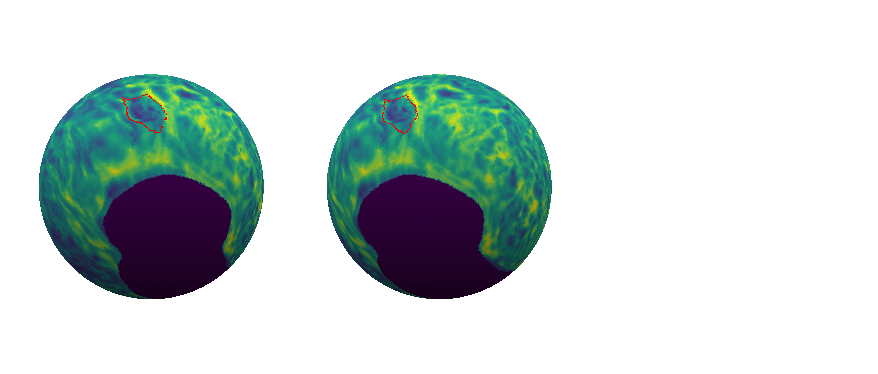

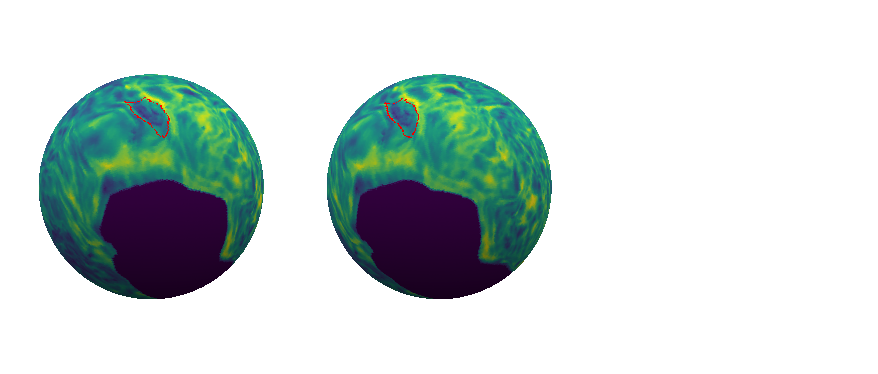

In [21]:
#plot feature on icosphere
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj[:,3], parcel=labels_subj, parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[270,250], 
                 )



# Plot spinned feature on icosphere
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              spinned_feature[:,3], parcel=spinned_lesion,parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[270,250],
                 )


In [7]:
from scipy.stats import ttest_ind
print(features_subj[:,0][labels_subj>0].mean())
print(spinned_feature[:,0][spinned_lesion>0].mean())
ttest_ind( features_subj[:,0][labels_subj>0], spinned_feature[:,0][spinned_lesion>0])

102.77413
103.672554


Ttest_indResult(statistic=-0.9749537019561735, pvalue=0.3296213180374049)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/co-ripa1/.conda/envs/meld_graph

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/vlgothic/VL-PGothic-Regular.ttf', name='VL PGothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/sil-nuosu/NuosuSIL.ttf', name='Nuosu SIL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/lohit-tamil/Lohit-Tamil.ttf', n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/tibetan-machine-uni/TibMachUni-1.901b.ttf', name='Tibetan Machine Uni', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-BoldItalic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/ipa-pgothic/ipagp.ttf', name='IPAPGothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuS

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Italic.ttf', name='Caladea', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/overpass/Overpass-Light-Italic.ttf', name='Overpass', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/lohit-nepali/Lohit-Nepali.ttf', name='Lohit Nepali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/open-sans/OpenSans-Regular.tt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/overpass/Overpass-ExtraLight Italic.ttf', name='Overpass', style='italic', variant='normal', weight=200, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Bold.ttf', name='Caladea', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-BoldItalic.otf', name='STIX', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.tt

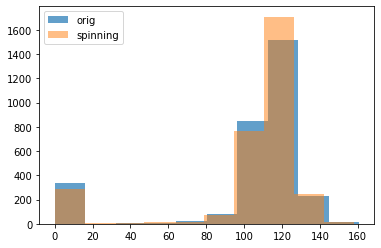

In [8]:
import matplotlib.pyplot as plt
plt.hist(features_subj[:,0][labels_subj>0], alpha=0.7, label='orig')
plt.hist(spinned_feature[:,0][spinned_lesion>0], alpha=0.5, label='spinning')
plt.legend()